# Practical 3: CIFAR-10

This is the second task of Practical 3. Your task is to use **transfer learning** to build a convolutional neural network to tackle the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). 
You could select an existing trained model (VGG16 excluded) from Keras (https://keras.io/api/applications/) and fine-tune it to build a classifier for CIFAR-10.

We will grade your code based on the accuracy of your model. 
Your CNN should achieve at least an accuracy of 75% to pass the practical.
You can get 5 bonus points by achieving an accuracy of 85%+.


The model files might be too large to be uploaded to GitHub. 
Please use the following link to upload your models: https://seafile.ifi.uzh.ch/u/d/695f63e725b641ed8633/

Name the model file `{repository_name}-CIFAR10.h5`. For example, if your repository is FDS22-M0, you should name the model file `FDS22-M0-CIFAR10.h5`. If you are not satisfied with the model you have uploaded, you can upload a new one with the same name. We will only look at the newest model. Nevertheless, try to upload as few times as possible, since the online drive has a limited amount of space. 

## Import the libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image

In [6]:
tf.__version__

'2.9.2'

In [7]:
tf.keras.__version__

'2.9.0'

## Prepare the dataset

In this block, you will prepare the data for the training, such as apply the preprocess function of your selected model and perform data augmentation. 

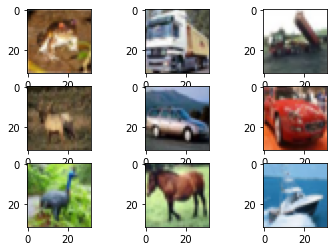

(50000, 32, 32, 3)

In [8]:
from keras.datasets import cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train_full[i])
plt.show()

X_train_full.shape

In [9]:
num_classes = 10

#Dataset preparation
  #Normalisation
X_train_full = X_train_full.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0

  #One hot encoding matrix
y_train_full = keras.utils.to_categorical(y_train_full, num_classes=num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes=num_classes)

  #Validation dataset
valid_size = 10000
np.random.seed(10) 
shuffled_indices = np.random.permutation(X_train_full.shape[0])
X_valid, X_train = X_train_full[shuffled_indices[:valid_size]], X_train_full[shuffled_indices[valid_size:]]
y_valid, y_train = y_train_full[shuffled_indices[:valid_size]], y_train_full[shuffled_indices[valid_size:]]

In [10]:
from keras.preprocessing.image import ImageDataGenerator

#Increase the Dataset 
  #Generators
train_gen = ImageDataGenerator(rotation_range=5, horizontal_flip=True, zoom_range=.2) #Training
val_gen = ImageDataGenerator(rotation_range=5, horizontal_flip=True, zoom_range=.2) #Valuation

train_gen.fit(X_train)
val_gen.fit(X_valid)

## Build and train the model

Build and train your model. 

In [11]:
# TODO: load the model you selected

# TODO: Transfer learning - build your own model based on the selected model

## DenseNet121

In [12]:
#Variables
trainable_layers = 10
shape = 224
neurons = 64

inputs = keras.Input(shape=(32, 32, 3))
upscale = keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x, shape, shape, method=tf.image.ResizeMethod.BILINEAR))(inputs) #Resizing the images

model = keras.applications.DenseNet121(include_top = True, weights='imagenet', input_tensor=upscale)
model.trainable = False

base_inputs = model.layers[0].input
base_outputs = model.layers[-2].output

add_outputs = keras.layers.BatchNormalization()(base_outputs)
add_outputs = keras.layers.Dense(8*neurons, activation='relu')(add_outputs)
add_outputs = keras.layers.Dropout(0.2)(add_outputs)
add_outputs = keras.layers.BatchNormalization()(add_outputs)
add_outputs = keras.layers.Dense(4*neurons, activation='relu')(add_outputs)
add_outputs = keras.layers.Dropout(0.2)(add_outputs)
add_outputs = keras.layers.BatchNormalization()(add_outputs)
add_outputs = keras.layers.Dense(neurons, activation='relu')(add_outputs)
add_outputs = keras.layers.Dropout(0.2)(add_outputs)
add_outputs = keras.layers.BatchNormalization()(add_outputs)

final_outputs = keras.layers.Dense(10, activation='softmax')(add_outputs)

DenseNetmodel = keras.Model(inputs=base_inputs, outputs=final_outputs)

for layer in DenseNetmodel.layers[-trainable_layers:]:
  layer.trainable = True

33188688/33188688 [==============================] - 1s 0us/step


In [13]:
# show the structure of your model
DenseNetmodel.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['lambda[0][0]']                 
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                             

In [14]:
DenseNetmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_DenseNet = DenseNetmodel.fit(train_gen.flow(X_train, y_train, batch_size=32),
                         epochs=20, validation_data=val_gen.flow(X_valid, y_valid))

Epoch 1/20
1250/1250 [==============================] - 166s 121ms/step - loss: 0.9449 - accuracy: 0.6785 - val_loss: 0.6392 - val_accuracy: 0.7764
Epoch 2/20
1250/1250 [==============================] - 148s 119ms/step - loss: 0.7493 - accuracy: 0.7480 - val_loss: 0.5907 - val_accuracy: 0.7969
Epoch 3/20
1250/1250 [==============================] - 151s 121ms/step - loss: 0.7004 - accuracy: 0.7645 - val_loss: 0.5527 - val_accuracy: 0.8088
Epoch 4/20
1250/1250 [==============================] - 152s 122ms/step - loss: 0.6475 - accuracy: 0.7794 - val_loss: 0.5365 - val_accuracy: 0.8122
Epoch 5/20
1250/1250 [==============================] - 153s 122ms/step - loss: 0.6298 - accuracy: 0.7837 - val_loss: 0.5258 - val_accuracy: 0.8188
Epoch 6/20
1250/1250 [==============================] - 149s 119ms/step - loss: 0.6014 - accuracy: 0.7958 - val_loss: 0.5110 - val_accuracy: 0.8190
Epoch 7/20
1250/1250 [==============================] - 151s 121ms/step - loss: 0.5888 - accuracy: 0.7989 - val_

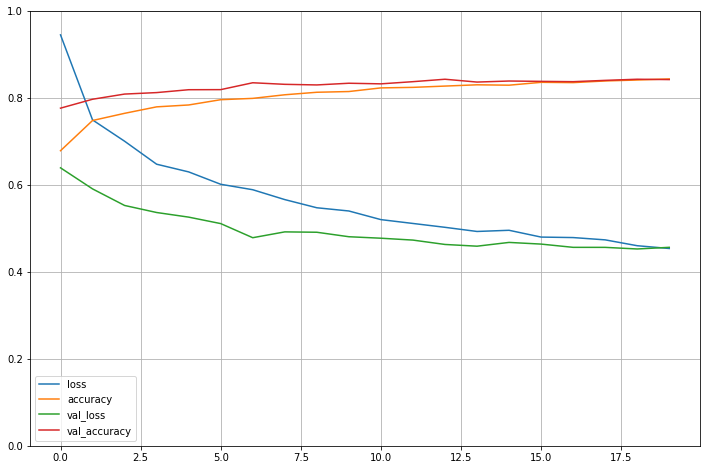

In [15]:
 # Assume you have stored the training history in the variable "history"
# Show the learning curves
pd.DataFrame(history_DenseNet.history).plot(figsize=(12, 8))
plt.gca().set_ylim(0, 1)
plt.grid(True)
plt.show()

## Save the model

Save and upload your trained model to the **Seafile link** we provided to you. You can upload it multiple times. We will consider only the newest uploaded model. 

In [16]:
DenseNetmodel.save('FDS22-M005-CIFAR10.h5') # change the file name according to your repository name

## Load the model and evaluate it on the test data

In [18]:
DenseNetmodel = keras.models.load_model('FDS22-M005-CIFAR10.h5')
DenseNetmodel.evaluate(X_test, y_test)

313/313 [==============================] - 30s 92ms/step - loss: 0.4073 - accuracy: 0.8679


[0.40729138255119324, 0.867900013923645]

## Short report

Please write a few sentences explaining how you build and train the model. Please include the decisions you made, such as how you decide the number of layers reused from the selected model and the difficulties you met.

# Model:
**VGG19:** 
First I tried to use the VGG19 Model. The input shape used was 224,224,3 therefore I had to resize the images from the CIFAR10 dataset which images have the shape 32,32,3. I tried different amounts of trainable layers but could not reach the target accuracy of 75%. Even with multiple Dense, dropout and Batch Normalization Layers I could not exceed the accuracy of 55%. I then tried to increase the variety of the training dataset by using the *ImageDataGenerator*. This yields to the current accuracy of 60%. The Jupyter Notebook for the VGG19 Model is also on GitHub.

**Densenet121:** The second pre-trained model I used was the DenseNet121. I used the same code as for the VGG19. I found that the accuracy is sufficient by using 10 trainable layers and using the input shape of 224,224,3, but with the higher image resolution the computation takes longer. The model provided was trained with 10 Epochs for said reasons, the accuracy increases by using 30 Epochs as proposed in the Code on GitHub.

Difficulties:
*   Finding a model which yields to the required accuracy
*   Resizing the images to fit the input shape of VGG19 (224,224,3)
*   Using a reasonable amount of Layers with corresponding paramenters to meet the accuracy
*   Google Colab GPU resources multiple timeouts because of high use (TPU was never available when I tried).



